# Imports and Loading data


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
import tensorflow_hub as hub

In [30]:
dataFiles = [
    "600_trans.tsv",
    "601_trans.tsv",
    "603_trans_3.tsv",
    "604_trans.tsv",
    "614_trans.tsv",
]

data = None

for dataFile in dataFiles:
    print("Processing file: " + dataFile)

    data = pd.concat(
        [data, pd.read_csv("input/" + dataFile, sep="\t")], ignore_index=True
    )

Processing file: 600_trans.tsv
Processing file: 601_trans.tsv
Processing file: 603_trans_3.tsv
Processing file: 604_trans.tsv
Processing file: 614_trans.tsv


In [31]:
data.head(10)

,name,features,transcript,cluster,number,hours,prefix
0,Course Introduction,"In the video, the instructor of the course ENM...","Well, greetings and welcome to the first lectu...",24,1.0,1.0,CEFA
1,Business Ethics,"In this lecture on business ethics, the instru...","Greetings. Hello again. In this lecture, we'll...",25,2.0,1.0,CEFA
2,Introduction to Managerial Finance and Accounting,"In this video, the instructor introduces stude...","Well, hello again and welcome back. In this le...",26,3.0,1.0,CEFA
3,Introduction to Accounting,"In this video, students will learn about the i...","Greetings. In this lecture, we're going to cov...",26,3.1,1.0,CEFA
4,Financial Statements - Income statements and r...,"In this video, the instructor introduces the i...",Greetings. In this lecture. We're going to beg...,26,3.2,1.0,CEFA
5,Financial Statements - Balance sheet,In the video transcript for the course ENMA 60...,Greetings In this lecture. We're going to cont...,26,3.3,1.0,CEFA
6,Financial Statements - Cash Flow,"In this video transcript, the instructor empha...","Hello again. In this lecture, we're going to c...",26,3.4,1.0,CEFA
7,Analyzing Financial Statements and Financial P...,The video introduces the concept of ratio anal...,Greetings Over the last several lectures we've...,26,3.5,1.0,CEFA
8,Analyzing Cash Flow,The key takeaway from this video is that analy...,Greetings. As we discussed in an earlier lectu...,27,4.0,1.0,CEFA
9,Cash and Profit Planning,"In this video, the instructor focuses on the i...","Hello again. In today's lecture, we're going t...",27,4.1,1.0,CEFA


# Preprocessing


In [32]:
sw = set(stopwords.words("english"))

In [33]:
sw.add("module")
sw.add("course")
sw.add("problem")
sw.add("use")
sw.add("model")
sw.add("solution")
sw.add("solve")
sw.add("analyze")
sw.add("example")
sw.add("application")
sw.add("computer")
sw.add("computers")
sw.add("zero")
sw.add("one")
sw.add("two")
sw.add("three")
sw.add("four")
sw.add("five")
sw.add("six")
sw.add("seven")
sw.add("eight")
sw.add("nine")
sw.add("x")
sw.add("c")
sw.add("k")
sw.add("l")
sw.add("b")
sw.add("go")
sw.add("constraint")
sw.add("get")
sw.add("ok")
sw.add("uh")
sw.add("shift")
sw.add("see")
sw.add("give")
sw.add("take")
sw.add("right")
sw.add("know")
sw.add("want")
sw.add("may")
sw.add("way")
sw.add("say")
sw.add("let")
sw.add("thing")
sw.add("look")
sw.add("need")
sw.add("would")
sw.add("try")
sw.add("back")
sw.add("also")
sw.add("must")
sw.add("okay")
sw.add("talk")
sw.add("well")
sw.add("like")
sw.add("basically")
sw.add("maybe")

In [34]:
data["combined"] = (
    "Title: "
    + data.name.str.strip()
    + "; Description: "
    + data.features.str.strip()
    + "; Transcript: "
    + data.transcript.str.strip()
)

In [35]:
def remove_stopwords(text):
    filtered_sentence = [w for w in text if not w in sw]
    return " ".join(filtered_sentence)

In [36]:
import string

# lowercase all words in the combined column of the data dataframe
data["combined"] = data["combined"].apply(lambda x: x.lower())

# remove newline characters from the combined column of the data dataframe
data["combined"] = data["combined"].apply(lambda x: x.replace("\n", " "))

# remove punctuation from the combined column of the data dataframe
data["combined"] = data["combined"].apply(
    lambda x: x.translate(str.maketrans("", "", string.punctuation))
)

# remove numbers from the combined column of the data dataframe
data["combined"] = data["combined"].apply(
    lambda x: x.translate(str.maketrans("", "", string.digits))
)

# tokenize the combined column of the data dataframe
data["combined"] = data["combined"].apply(lambda x: word_tokenize(x))

# remove stopwords from the combined column of the data dataframe
data["combined"] = data["combined"].apply(
    lambda x: [word for word in x if word not in sw]
)

In [37]:
w2v = data.copy()

# Embedding Models


## Word2Vec


In [38]:
word2vec = Word2Vec(
    sentences=w2v["combined"].values, min_count=3, sg=1, window=15, workers=8
)

In [39]:
for index, word in enumerate(word2vec.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(word2vec.wv.index_to_key)} is {word}")

word #0/6856 is going
word #1/6856 is project
word #2/6856 is time
word #3/6856 is thats
word #4/6856 is people
word #5/6856 is point
word #6/6856 is value
word #7/6856 is cost
word #8/6856 is lets
word #9/6856 is cash


In [40]:
word2vec.wv.most_similar("finance")

[('managerial', 0.8330912590026855),
 ('accounting', 0.771922767162323),
 ('pertains', 0.7181880474090576),
 ('enterprise', 0.6977056264877319),
 ('categories', 0.696458637714386),
 ('distinction', 0.6878256797790527),
 ('linked', 0.6765718460083008),
 ('familiarize', 0.6760386228561401),
 ('distinguishes', 0.6758193373680115),
 ('externally', 0.6741073727607727)]

In [41]:
emb_df = pd.DataFrame(
    [word2vec.wv.get_vector(str(n)) for n in word2vec.wv.key_to_index],
    index=word2vec.wv.key_to_index,
)
print(emb_df.shape)
emb_df.head()

(6856, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
going,0.085243,0.157468,-0.192399,-0.185325,-0.028747,-0.186036,-0.161759,-0.089304,-0.099167,-0.197890,...,0.209887,0.057020,-0.062246,0.142540,0.367100,-0.001928,0.316490,-0.365746,0.008117,-0.463776
project,-0.639205,0.360163,-0.104855,-0.215591,0.084465,-0.060828,-0.128324,0.000619,-0.295998,-0.168203,...,0.467195,-0.424273,-0.597542,0.031750,0.186044,-0.008549,0.243202,-0.465264,-0.166421,-0.380625
time,-0.145789,-0.006169,0.014603,-0.051629,0.082565,-0.006361,-0.422384,-0.160239,-0.274523,-0.075997,...,0.035458,-0.044764,-0.086229,-0.027596,0.375702,-0.280453,0.205905,-0.023204,-0.040806,-0.008253
thats,0.118156,0.063894,0.014768,-0.044497,-0.025852,0.070771,-0.336533,-0.165536,-0.140816,0.053472,...,0.156759,0.090697,0.060953,0.362519,0.208859,-0.286893,0.303027,-0.144327,0.009967,-0.219491
people,0.132764,0.032639,0.175669,-0.309642,0.143697,-0.108661,-0.311319,-0.208532,-0.233559,-0.289300,...,0.084372,0.121672,0.186560,-0.315584,-0.033814,0.264529,0.076735,-0.231524,-0.044585,-0.129698


In [42]:
emb_df.to_csv("output/w2v_embeddings.tsv", index=True, sep="\t", header=False)

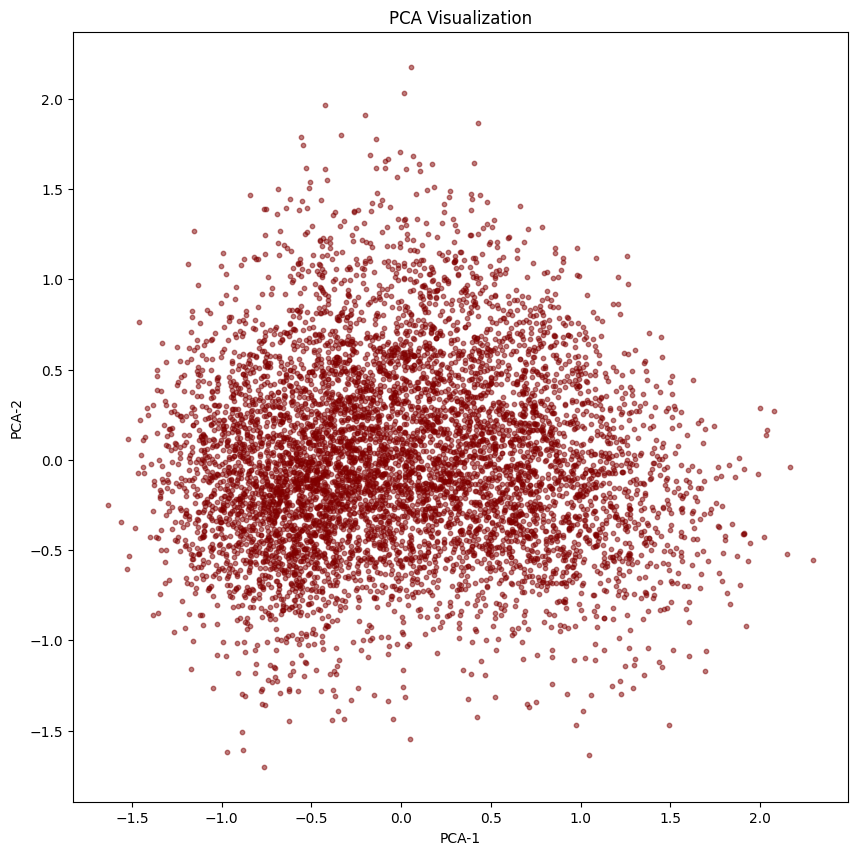

In [43]:
pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = pd.DataFrame(pca_mdl, columns=["x", "y"], index=emb_df.index)

fig = plt.figure(figsize=(10, 10))

plt.scatter(x=emb_df_PCA["x"], y=emb_df_PCA["y"], s=10, color="maroon", alpha=0.5)

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title("PCA Visualization")
plt.plot()
plt.show()

In [44]:
tsne = TSNE(
    n_components=2, random_state=42, perplexity=16, learning_rate=10, n_iter=3000
)

tsne_results = tsne.fit_transform(emb_df)

tsne_df = pd.DataFrame(tsne_results, columns=["x", "y"])

tsne_df["label"] = emb_df.index

tsne_df.head()

,x,y,label
0,7.045124,-11.747548,going
1,-2.070537,5.765224,project
2,8.556339,-14.338842,time
3,29.795496,-29.672977,thats
4,-35.380440,-17.918261,people


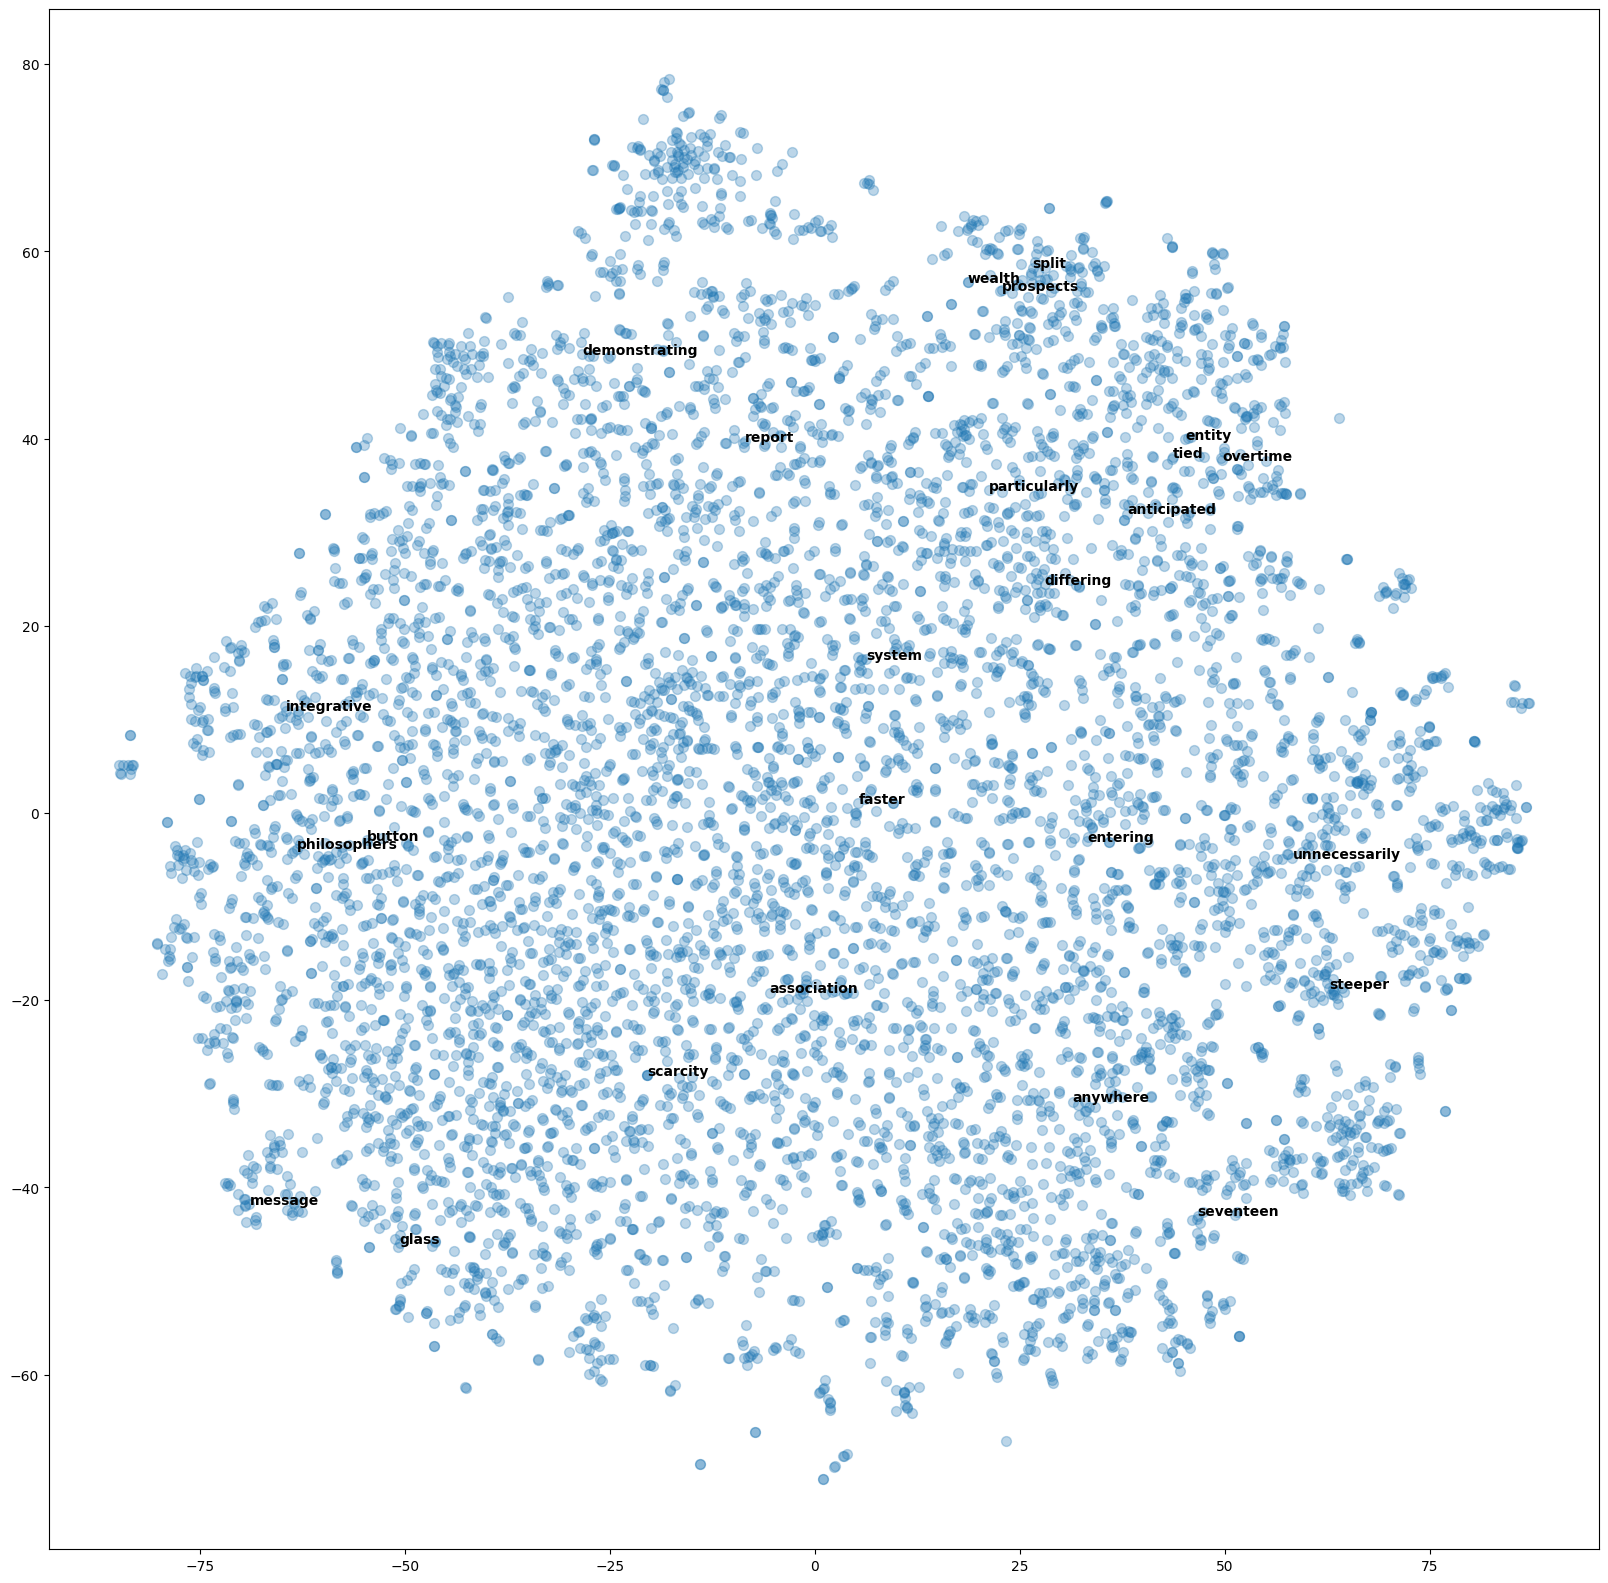

In [45]:
# plot x and y using matplotlib with label as a text on a radom 25 sample of the dataset

plt.figure(figsize=(20, 20))
plt.scatter(tsne_df.x, tsne_df.y, s=50, alpha=0.3)

annot_array = np.random.choice(tsne_df.index, 25, replace=False)

for i in annot_array:
    plt.text(
        s=tsne_df.label[i],
        x=tsne_df.x[i],
        y=tsne_df.y[i],
        fontdict={"fontsize": 10, "fontweight": "bold"},
    )

plt.show()

## Doc2Vec


In [46]:
# set up dataset for doc 2 vector embedding

d2v = data.copy()

In [49]:
doc2vec = Doc2Vec(vector_size=100, min_count=2, epochs=100)

## BERT


In [56]:
!pip install tensorflow-text

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ERROR: Could not find a version that satisfies the requirement tensorflow-text (from versions: none)
ERROR: No matching distribution found for tensorflow-text

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [55]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
)
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True
)

RuntimeError: Op type not registered 'CaseFoldUTF8' in binary running on ENGR898D. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.

In [52]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[: max_len - 2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

NameError: name 'bert_layer' is not defined

In [54]:
from sklearn.linear_model import LogisticRegression
import transformers
import torch

corpus = data.copy()
model_name = "bert-base-uncased"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModel.from_pretrained(model_name)


def embed(text):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)
    with torch.no_grad():
        output = model(input_ids)
    embeddings = output.last_hidden_state.mean(dim=1).squeeze()
    return embeddings.numpy()


# each value of the combined column is a list of words
# we must convert it to a string for the embed function
corpus["text"] = corpus.combined.apply(lambda x: " ".join(x))

corpus["embeddings"] = corpus.text.apply(embed)

# embeddings = [embed(doc) for doc in corpus.text]

# X = pd.DataFrame(embeddings)
# y = data.cluster

# clf = LogisticRegression().fit(X, y)

# new_doc = [
#     "Introduction to Corporate Finance",
#     "Project Management for Business Professionals",
#     "Introduction to Marketing",
# ]
# new_embeddings = [embed(doc) for doc in new_doc]
# X_new = pd.DataFrame(new_embeddings)
# predicted = clf.predict(X_new)
# print(predicted)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Token indices sequence length is longer than the specified maximum sequence length for this model (2630 > 512). Running this sequence through the model wil

RuntimeError: The expanded size of the tensor (2630) must match the existing size (512) at non-singleton dimension 1.  Target sizes: [1, 2630].  Tensor sizes: [1, 512]

In [53]:
X.index = data.name.values

pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(X)

bert_df_PCA = pd.DataFrame(pca_mdl, columns=["x", "y"], index=X.index)

fig = plt.figure(figsize=(20, 20))

plt.scatter(
    x=bert_df_PCA["x"],
    y=bert_df_PCA["y"],
    s=50,
    cmap="tab10",
    alpha=0.5,
    c=data.cluster.values,
)

for i, txt in enumerate(bert_df_PCA.index):
    plt.annotate(txt, (bert_df_PCA["x"][i], bert_df_PCA["y"][i]))

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title("PCA Visualization")
plt.plot()
plt.show()

NameError: name 'X' is not defined

## Sent2Vec
